In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scipy.sparse

# Load Data

In [147]:
#**************
# with NaNs
# tX
#tX_path=os.path.join( os.getcwd(), "..", "data", "training-data-pca-with-dummy-vars-with-NaNs.csv")
#tX_path=os.path.join( os.getcwd(), "..", "data", "training-data-whitened-with-dummy-vars-with-NaNs.csv")
#tX_path=os.path.join( os.getcwd(), "..", "data", "training-data-standardized-with-dummy-vars-with-NaNs.csv")
#tX_path=os.path.join( os.getcwd(), "..", "data", "training-data-standardized-with-dummy-vars-with-NaNs-removed-corr.csv")
tX_path=os.path.join( os.getcwd(), "..", "data", "training-data-whitened-using-PCA-with-dummy-vars-with-NaNs.csv")
# y
y_path=os.path.join( os.getcwd(), "..", "data", "y-labels.csv")


#**************
# no NaNs
# tX
#tX_path=os.path.join( os.getcwd(), "..", "data", "training-data-standardized-with-dummy-vars-no-NaNs-removed-corr.csv")
# y
#y_path=os.path.join( os.getcwd(), "..", "data", "y-labels-no-NaNs.csv")

tX = np.loadtxt(tX_path)
y = np.loadtxt(y_path)

In [148]:
N_SAMPLES = tX.shape[0]
print(N_SAMPLES)
print(y.shape[0])
print(tX.shape)

250000
250000
(250000, 31)


In [149]:
y_colors = np.array(['b']*N_SAMPLES)
y_colors[y==0] = 'r'
print("Found {b} boson events out of {N} total events".format(b=np.sum(y), N=N_SAMPLES))
# If I understood correctly, 1 are bosons, i.e. boson events will be colored in blue

Found 85667.0 boson events out of 250000 total events


# Logistic Regression

In [150]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1/(1+np.exp(-t))

In [151]:
def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    Xw = tx.dot(w)
#    print(Xw.shape)
#    print(y.shape)
    LOG_part = np.log( 1 + np.exp( Xw ) )
#    print(LOG_part.shape)
    PROD_part = np.multiply(y.reshape(N_SAMPLES,1), Xw )
#    print(PROD_part.shape)
    a = LOG_part - PROD_part
    return np.sum( a )

In [152]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    return tx.T.dot( sigmoid(tx.dot(w)) - y.reshape((tx.shape[0],1)) )

## Gradient Descent

In [ ]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """

    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y,tx, w)
    w -= gamma*grad
    
    return loss, w

In [ ]:
from helpers import de_standardize
from plots import visualization

def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 0.001
    losses = []

    # build tx
    tx = np.c_[.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return losses, w

In [ ]:
losses, w_star = logistic_regression_gradient_descent_demo(y, whit_tX)
#print(w_star.shape)
#print(w_star)

In [ ]:
f = plt.figure()
ax=f.add_subplot(2,1,1)
ax.scatter(whit_tX[:,0],whit_tX[:,1], c=y_colors, alpha=0.1)

ax=f.add_subplot(2,1,2)
prediction = sigmoid(whit_tX[:,0:1].dot(w_star[1:2]))
prediction = prediction < 0.5
#ax.plot(prediction)
ax.scatter(whit_tX[:,0],whit_tX[:,1], c=prediction, alpha=0.1)



In [ ]:
error = np.sum(np.abs(prediction - y.reshape(N_SAMPLES,1)))
print(error)
print(error/N_SAMPLES)

## Newton's Method

In [153]:
def calculate_hessian(y, tx, w):
    """return the hessian of the loss function."""
    S1 = sigmoid(tx.dot(w))
    S1 = S1.reshape((N_SAMPLES,1))
#    print(S1.shape)
    S2 = 1.0 - sigmoid(tx.dot(w))
#    print(S2.shape)
    S = np.multiply(S1,S2)
#    print(S.shape)
    S = scipy.sparse.spdiags(S[:,0], 0, N_SAMPLES, N_SAMPLES)
    return tx.T.dot(S.dot(tx))

In [154]:
def logistic_regression(y, tx, w):
    """return the loss, gradient, and hessian."""
    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y,tx, w)
    hess = calculate_hessian(y, tx, w)
    return loss, grad, hess

In [155]:
def learning_by_newton_method(y, tx, w, gamma):
    """
    Do one step on Newton's method.
    return the loss and updated w.
    """
    loss, grad, hess = logistic_regression(y,tx,w)
    w -= gamma * np.linalg.inv(hess).dot(grad);
    return loss, w

In [156]:
def logistic_regression_newton_method_demo(y, x, w_initial):
    # init parameters
    max_iter = 1000
    gamma = 0.1
    threshold = 1e-8
    lambda_ = 0.1
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = w_initial

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_newton_method(y, tx, w, gamma)
        # log info
        if iter % 5 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2])/np.abs(losses[-1]) < threshold:
            print("[Exit Condition Met]: Current iteration={i}, the loss={l}".format(i=iter, l=loss)) 
            break
    return losses, w

In [157]:
w0 = np.random.rand(tX.shape[1]+1,1)
losses, w_star = logistic_regression_newton_method_demo(y, tX, w0)

Current iteration=0, the loss=437587.16299980076
Current iteration=5, the loss=166570.62675234012
Current iteration=10, the loss=141893.75300958785
Current iteration=15, the loss=131792.08267272892
Current iteration=20, the loss=127223.14954957462
Current iteration=25, the loss=125191.4709136044
Current iteration=30, the loss=124330.92174666835
Current iteration=35, the loss=123985.03406371418
Current iteration=40, the loss=123852.10911898686
Current iteration=45, the loss=123802.7274182022
Current iteration=50, the loss=123784.80815031199
Current iteration=55, the loss=123778.40497734795
Current iteration=60, the loss=123776.13895056688
Current iteration=65, the loss=123775.34177772989
Current iteration=70, the loss=123775.06234414037
Current iteration=75, the loss=123774.96460474705
Current iteration=80, the loss=123774.93046157707
Current iteration=85, the loss=123774.9185434615
[Exit Condition Met]: Current iteration=86, the loss=123774.91733061887


## Compute Predictions

In [158]:
tX_pred = np.c_[np.ones((y.shape[0], 1)), tX]
prediction = sigmoid(tX_pred.dot(w_star))
prediction = np.array( [ int(x) for x in (prediction > 0.5)] )

## Plot predictions

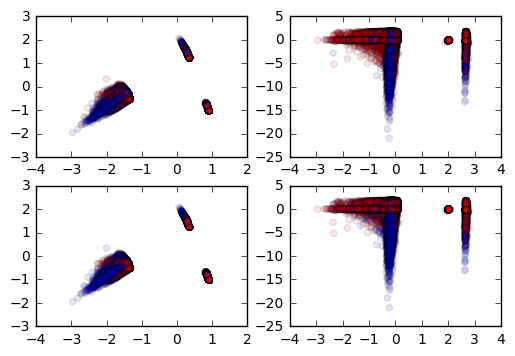

In [159]:
f = plt.figure()
ax=f.add_subplot(2,2,1)
ax.scatter(tX[:,0],tX[:,1], c=y_colors, alpha=0.1)

ax=f.add_subplot(2,2,2)
ax.scatter(tX[:,2],tX[:,3], c=y_colors, alpha=0.1)

prediction_colors = np.array(['b']*N_SAMPLES)
prediction_colors[prediction==0] = 'r'

ax=f.add_subplot(2,2,3)
ax.scatter(tX[:,0],tX[:,1], c=prediction_colors, alpha=0.1)

ax=f.add_subplot(2,2,4)
ax.scatter(tX[:,2],tX[:,3], c=prediction_colors, alpha=0.1)

## Compute training error

In [160]:
error = np.sum(np.abs(prediction - y))
print(prediction)
print(y)
print(error)
print(error/N_SAMPLES)

[0 1 0 ..., 0 1 0]
[ 1.  0.  0. ...,  1.  0.  0.]
61908.0
0.247632
